# Import Libraries

Import required libraries

In [11]:
import itertools
import numpy as np
from scipy import stats
import pylab as pl
import pickle
import json
import h5py
import matplotlib.pyplot as plt
import tqdm
import os
import skimage
from skimage.feature import ORB
from skimage.color import rgb2gray
from sklearn.cluster import KMeans
from tqdm import tqdm
import cv2
from pathlib import Path
from scipy import spatial
from scipy.spatial.distance import cityblock

In [12]:
cv2.__version__

'4.5.4-dev'

# Load images from files

In [13]:
def load_images():
    # DATASET
    with open("data02/database/database_lite.json","r") as f:
        m_idx = json.load(f)
        m_imgs = np.array(m_idx["im_paths"])
        m_loc = np.array(m_idx["loc"])

    # QUERY IMAGES
    with open("data02/query/query_lite.json","r") as f:
        q_idx = json.load(f)
        q_imgs = np.array(q_idx["im_paths"])
        q_loc = np.array(q_idx["loc"])
    return m_imgs, q_imgs


Load Reduced Dataset

In [14]:
# LITE VERSION
m_imgs, q_imgs = load_images()
    
print("Number of Lite Database images: "+ str(len(m_imgs)))
print("Number of Lite Query images : "+ str(len(q_imgs)))


Number of Lite Database images: 1000
Number of Lite Query images : 500


# Performance Metric Functions

In [15]:
def r_precision(relevant, retrieved):
    rel = len(relevant)
    retr = retrieved[:rel]
    rel_in_retr = [x for x in retr if x in relevant]
    if rel!=0:
        return len(rel_in_retr)/rel
    else:
        return 0

def recall_at_k(relevant, retrieved, k):
    rel = len(relevant)
    retr = retrieved[:k]
    rel_in_retr = [x for x in retr if x in relevant]
    if rel!=0:
        return len(rel_in_retr)/rel
    else:
        return 0
    
def average_precision(relevant, retrieved):
    total_relevant = len(relevant)
    relevant_retrieved = 0
    total_precision = 0
   
    for (rank, docid) in enumerate(retrieved, 1):
        if docid in relevant:
            relevant_retrieved += 1
            total_precision += relevant_retrieved / rank
    if total_relevant!=0:
        avp = total_precision / total_relevant
        return avp
    else:
        return 0

def mean_r_precision(all_relevant, all_retrieved):
    total = 0
    count = 0
    for qid in range(len(all_relevant)):
        relevant  = all_relevant[qid]
        retrieved = all_retrieved[qid]
        value = r_precision(relevant, retrieved)
        total += value
        count += 1
    return total / count

def mean_recall_at_k(all_relevant, all_retrieved, k):
    total = 0
    count = 0
    for qid in range(len(all_relevant)):
        relevant  = all_relevant[qid]
        retrieved = all_retrieved[qid]
        value = recall_at_k(relevant, retrieved, k)
        total += value
        count += 1
    return total / count

def mean_average_precision(all_relevant, all_retrieved):
    total = 0
    count = 0
    for qid in range(len(all_relevant)):
        relevant  = all_relevant[qid]
        retrieved = all_retrieved[qid]
        value = average_precision(relevant, retrieved)
        total += value
        count += 1
    return total / count

# ORB
Funtion definition to extract ORB descriptors

In [16]:
def get_orb(n_keypoints="default"):
    if n_keypoints!="default":
        descriptor_extractor = ORB(n_keypoints=n_keypoints)
    else:
        descriptor_extractor = ORB()
    descriptors = None

    # Loop over map images and find descriptors and stack them
    for img_name in m_imgs:
        img = plt.imread(os.path.join('data02/', img_name))
        img = rgb2gray(img)
        
        # Extract ORB descriptors
        descriptor_extractor.detect_and_extract(img)  
        descriptors_img = descriptor_extractor.descriptors  # descriptors (the feature vectors)

        # Accumulate the computed descriptors
        if descriptors is None:
            descriptors = descriptors_img
        else:
            descriptors = np.vstack( (descriptors, descriptors_img))

    print("Descriptors shape: ", descriptors.shape)
        
    if n_keypoints!="default" :
        num = str(n_keypoints)
    else:
        num = n_keypoints
    return descriptor_extractor, descriptors, num

# Clustering
Funtion definition to cluster the descriptors based on K number of centroids

In [17]:
def kmeans(K, descriptors, desc, num):
    num_initialization = 2 

    # Run the k-means clustering and find the centroids. The centroids act as visual words for the whole dataset
    kmeans = KMeans(n_clusters=K, random_state=0, n_init=num_initialization, verbose=0)
    clusters = kmeans.fit(descriptors)  
    centroids = clusters.cluster_centers_

    print("Shape of the centroids matrix: ", centroids.shape)
    print("We computed ", centroids.shape[0], "centroids of lengh ", centroids.shape[1], " (the same of the descriptor)")
    
    return clusters, centroids

# Visual Bag of Words (VBOW)
Funtion definition to return VBOW vector representation for all database images

In [23]:
# Compute the VBOW vector for an individual image
def bag_of_words(centroids, img_descriptors, dist_measure="none"):
    n_centroids = centroids.shape[0]  # Number of centroids found with the KMeans clustering
    n_descriptors = img_descriptors.shape[0]  # Number of descriptors extracted from the image
    
    bow_vector = np.zeros(n_centroids)
    # Obtain the VBOW vector which is like a histogram of nearest centroid for each descriptor
    for i in range(n_descriptors):
        dist = []
        if dist_measure=="cosine":
            for j in centroids:
                dist.append( spatial.distance.cosine(j, img_descriptors[i]) )
        idx = np.argsort(dist)[0] # Find the index of the closest centroid
        bow_vector[idx]+=1 # Increment the count corresponding to the closest centroid
    return bow_vector

# Compute the VBOW vectors for all images in the dataset
def bow_f(centroids, descriptor_extractor, star, desc, dist_measure="none"):    
    bow_map_images = None
    
    # Loop over the images in the map set and find their VBOW vectors
    for img_name in tqdm(m_imgs):
        img = plt.imread(os.path.join('data02/', img_name))

        # Extract the Keypoints and descriptors of each image
        if desc == "orb":
            img = rgb2gray(img)
            descriptor_extractor.detect_and_extract(img)
            img_descriptors = descriptor_extractor.descriptors  # descriptors (the feature vectors)
        elif desc == "sift":
            img= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            kp, img_descriptors = descriptor_extractor.detectAndCompute(img, None)
        elif desc == "BRIEF":
            img= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            kp = star.detect(img,None)
            kp, img_descriptors = descriptor_extractor.compute(img, kp)           

        # Compute the VBOW vector for each of the words
        bow = bag_of_words(centroids, img_descriptors, dist_measure)
        
        # Stack the VBOW vectors
        if bow_map_images is None:
            bow_map_images = bow
        else:
            bow_map_images = np.vstack( (bow_map_images, bow))

    orig_bow_map_images = bow_map_images

    # Compute z-score statistics and normalise it
    scaler = preprocessing.StandardScaler().fit(bow_map_images)
    bow_map_images = scaler.transform(bow_map_images)
    
    return bow_map_images, scaler

# Retrieve Images
Funtion definition to retrieve images for the query images

In [32]:
# Find the most similar VBOW vectors(image) for a query image using Cosine distance
def retrieve_images(map_bow_vectors, query_bow, dist="none"):
    n_map_bow_vectors = map_bow_vectors.shape[0]
    bow_distances = np.zeros(n_map_bow_vectors)
    most_similar = None 
    
    distances = []
    
    if dist=="cosine":
        for i in map_bow_vectors:
            distances.append( spatial.distance.cosine(i, query_bow) ) # Find the distance with each dataset image
    most_similar = np.argsort(distances) # Sort the distances
    return most_similar # Return the list of image indices in sorted order

# Retrieve similar images for all query images
def retrieve(m_imgs, bow_map_images, descriptor_extractor, scaler, star, desc, dist="none"):
    retrieved_images = list()
    relevant_images = list()
    
    # For all query image, retrieve similar images
    for query_idx in tqdm(range(200,205)):
        img = plt.imread("data02/" + q_imgs[query_idx])

        # Compute VBOW vector of the query image
        if desc == "orb":
            img = rgb2gray(img)
            descriptor_extractor.detect_and_extract(img)  
            query_img_descriptors = descriptor_extractor.descriptors 
            
        bow = bag_of_words(centroids, query_img_descriptors, dist) # Compute VBOW of query image

        # Normalize the query VBOW vector 
        bow = scaler.transform(bow.reshape(-1, 1).transpose())
        bow = bow.transpose().reshape(-1)

        retrieved_images.append(retrieve_images(bow_map_images, bow, dist)) # Append the list of similar images
        
    return retrieved_images, relevant_images # Return the final output

# Results of retrieval

## Find the descriptors of all images in the dataset

In [20]:
descriptor_extractor, descriptors, num = get_orb(350)

Descriptors shape:  (349451, 256)


## Cluster the descriptors using K-means algorithm

In [ ]:
clusters, centroids = kmeans(300, descriptors, "orb", num)

## Compute the VBOW vectors of all Dataset images

In [24]:
bow_map_images, scaler = bow_f(centroids, descriptor_extractor,None, "orb", "cosine")

100%|███████████████████████████████████████| 1000/1000 [52:54<00:00,  3.17s/it]


## Retrieve similar images for few query images

In [33]:
retrieved_images, relevant_images = retrieve(m_imgs, bow_map_images, descriptor_extractor, scaler,None, "orb", "cosine")

100%|█████████████████████████████████████████████| 5/5 [00:15<00:00,  3.05s/it]


# Sample Output

(-0.5, 340.5, 255.5, -0.5)

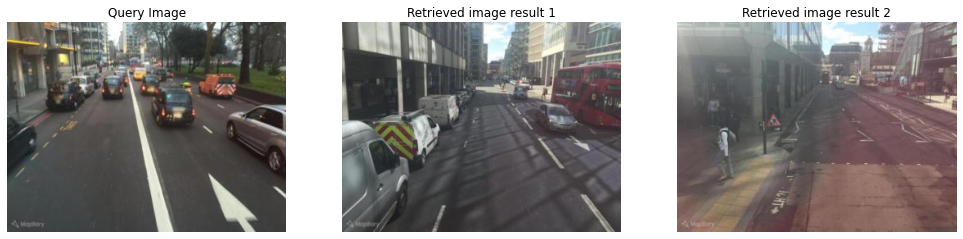

In [46]:
plt.figure(figsize=(17,10))
plt.subplot(1,3,1)
plt.title('Query Image')
plt.imshow(plt.imread('data02/' + q_imgs[201])) # Query Image
plt.axis("off")

plt.subplot(1,3,2)
plt.title('Retrieved image result 1')
plt.imshow(plt.imread('data02/' + m_imgs[retrieved_images[1][0]])) # Most similar image
plt.axis("off")

plt.subplot(1,3,3)
plt.title('Retrieved image result 2')
plt.imshow(plt.imread('data02/' + m_imgs[retrieved_images[1][1]])) # Second most similar image
plt.axis("off")